# Вариант 3. Использование Contrastive Loss

В данном подходе для классификации лиц будут использовать эмбеддинги, полученные от ResNet18 при обучении на Contrastive Loss, который штрафует за увеличение косинусного расстояния между похожими объектами. Оцениваются эмбеддигы с помощью классификации на тестовой выборке: 
- путем выборки из обучающих данных векторов, которые имеют наименьшее расстояние с тестовыми данными
- использование векторов в качестве фичей для полносвязной сети
- использованием векторов в качестве фичей для SVM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv2
from os.path import join
import os
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torch.nn.functional as F
import wandb

In [2]:
def view_random_images(cols, rows, path_to_images):
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1), layout="tight")
    images = os.listdir(path_to_images)
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid("off")
            ax.axis("off")
            img = cv2.imread(os.path.join(path_to_images, images[random_index]))
            ax.imshow(img[..., ::-1])
            size = img.shape
            plt.title(f'{images[random_index].split(".")[0]}, size={size}', fontsize=5)

    plt.show()

Использовать буду уже обрезанные и выравненные до единого размера лица из датасета.

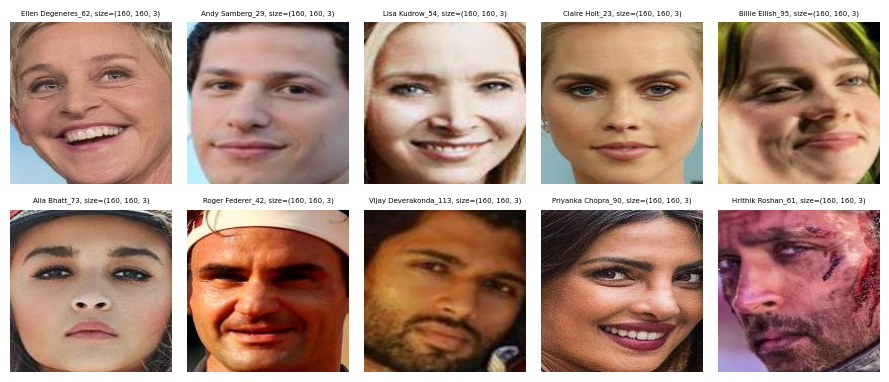

In [3]:
view_random_images(5, 2, "Faces")

Основные параметры обучения задаются для ResNet при обучении на создание эмбедингов, а также для полносвязной сети.

In [4]:
BATCH_SIZE_CLASS = 8
# for embedding trainings
BATCH_SIZE_TRIPLET = 64
num_epochs_triplet = 15
learning_rate_triplet = 0.001
with_scheduler_triplet = True
use_combos = True
combos_mult = 2
experiment_name_triplet = f"Tripl{BATCH_SIZE_TRIPLET}_{num_epochs_triplet}_{with_scheduler_triplet}_{use_combos}"


# for classification
BATCH_SIZE_CLASS = 8
num_epochs_class = 50
learning_rate_class = 0.0001
input_features = 512
with_scheduler_class = False
experiment_name_class = (
    f"ResNClass{BATCH_SIZE_CLASS}_{num_epochs_class}_{with_scheduler_class}"
)

Сперва обработаю изображения и соберу все данные в датафрейм.

In [5]:
def prepare_data(path_to_data):
    df = pd.DataFrame()
    for filename in tqdm(os.listdir(path_to_data)):
        full_path = join(path_to_data, filename)
        img = cv2.imread(full_path)
        label = filename.split(".")[0]
        label = label.split('_')[0]
        new_row = {'label_string': label,
                   'image': img}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    data_classes = list(set(df["label_string"].tolist()))
    df["label"] = df["label_string"].apply(data_classes.index)
    df = df.drop(['label_string'], axis = 1)
    df = df[['label', 'image']]
    return df

In [6]:
df = prepare_data('Faces')
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=202
)

  0%|          | 0/2562 [00:00<?, ?it/s]

In [7]:
default_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

Создам функцию для создания датасета для обучения на Contrastive Loss. Датасет будет включать:

- пару разных изображений одного человека с меткой 0, т.е. расстояние минимально
- пару изображений разных людей с меткой 1, т.е. расстояние максимально
- оставлю также метку класса, чтобы можно было провести оценку качества эмбеддингов.

Добавлю в качестве параметров возможность аугментации, т.е. составления комбинаций из изображений одного человека (это ограничивающий фактор аугментации, так как пар изображений с другими людьми может быть больше).

Таже добавлю коэффициент аугментации, т.е. какую часть всех возможных комбинаций будет использовано. Например, коэфф 2 говорит о том, что будет использована только половина возможных комбинаций.

In [8]:
class ContrastiveLossDataset(Dataset):
    def __init__(self, data_df: pd.DataFrame, transform=None, use_all_combos = False, combos_mult = 2):
        super(ContrastiveLossDataset, self).__init__()
        dataset = []
        labels_positive = {}
        labels_negative = {}

        # for each label create a set of same label images.
        for i in list(data_df.label.unique()):
            labels_positive[i] = data_df[data_df.label == i]['image'].to_numpy()
        # for each label create a set of image of different label.
        for i in list(data_df.label.unique()):
            labels_negative[i] = data_df[data_df.label != i]["image"].to_numpy()

        for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
            # label and image of the index for each row in df
            label = row['label']

            if use_all_combos:
                # probability of same label image == 0.5
                if np.random.randint(0, 2) == 0:
                    for i in range(int(len(labels_positive[label]) / combos_mult)):
                        second = labels_positive[label][i]
                        dis = 0.0
                        first = row["image"]
                        if transform is not None:
                            first = transform(first.astype(np.float32))
                            second = transform(second.astype(np.float32))
                        dataset.append((first, second, dis, label))
                else:
                    for i in range(int(len(labels_positive[label]) / combos_mult)):
                        second = labels_negative[label][
                            np.random.randint(0, len(labels_negative[label]))
                        ]
                        first = row["image"]
                        dis = 1.0
                        if transform is not None:
                            first = transform(first.astype(np.float32))
                            second = transform(second.astype(np.float32))
                        dataset.append((first, second, dis, label))
            else:
                if np.random.randint(0, 2) == 0:
                    second = labels_positive[label][
                        np.random.randint(0, len(labels_positive[label]))
                    ]
                    dis = 0.0
                    first = row["image"]
                    if transform is not None:
                        first = transform(first.astype(np.float32))
                        second = transform(second.astype(np.float32))
                    dataset.append((first, second, dis, label))
                else:
                    second = labels_negative[label][
                        np.random.randint(0, len(labels_negative[label]))
                    ]
                    first = row["image"]
                    dis = 1.0
                    if transform is not None:
                        first = transform(first.astype(np.float32))
                        second = transform(second.astype(np.float32))
                    dataset.append((first, second, dis, label))
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.dataset[i]

In [9]:
train_dataset_with_combos = ContrastiveLossDataset(train_df, default_transform, use_all_combos=use_combos, combos_mult=combos_mult)
test_dataset = ContrastiveLossDataset(test_df, default_transform)

print(f"Train dataset shape: {len(train_dataset_with_combos)}")
print(f"Test dataset shape: {len(test_dataset)}")

  0%|          | 0/2049 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

Train dataset shape: 72358
Test dataset shape: 513


In [10]:
# shuffle true for train data to randomly create batches
trainLoader_with_combos = DataLoader(
    train_dataset_with_combos,
    batch_size=BATCH_SIZE_TRIPLET,
    shuffle=True,
    drop_last=True,
)
valLoader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_TRIPLET,
    shuffle=False,
    drop_last=True,
)

Добавлю модуль Identity в модель, который заменить последний классификационный слой.

In [11]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [12]:
def get_model():
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    model.fc = Identity()
    return model

Создам функцию для расчета Contrastive Loss. Реализаций его может быть несколько, я воспользуюсь представленной авторами на https://github.com/HarshSulakhe/siamesenetworks-pytorch/tree/master. Основная цель обучения - максимально сблизить похожие вектора и удалить отличающиеся.

In [13]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1 - label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(
            torch.clamp(self.margin - euclidean_distance, min=0.0), 2
        )
        loss_contrastive = torch.mean(pos + neg)
        return loss_contrastive

Создаем сеть на основе ResNet

In [14]:
class ContrastiveLossModel(pl.LightningModule):
    def __init__(self, num_epochs, learning_rate, with_scheduler = True):
        super().__init__()
        self.model = get_model()

        self.loss_fn = ContrastiveLoss()
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.with_scheduler = with_scheduler

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        first, second, dis, label = batch
        first_out = self.model(first)
        second_out = self.model(second)
        dis = dis.to(torch.float32)
        loss = self.loss_fn(first_out, second_out, dis)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        first, second, dis, label = batch
        first_out = self.model(first)
        second_out = self.model(second)
        loss = self.loss_fn(first_out, second_out, dis)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        if self.with_scheduler:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=7, gamma=0.3
            )
            return [optimizer], [scheduler]
        else:
            return [optimizer]

Запускаем обучение.

Я запустила 4 эксперимента, изменяя кол-во данных при обучении:

- 1 - использовала 1/8 всех комбинаций
- 2 - обучение без дополнительных комбинций, т.е рандомно подбирается всего один положительный пример
- 3 - обучение на 1/4 всех комбинаций
- 4 - обучение на 1/2 всех комбинаций

Ниже как раз логирование последнего эксперимента на 1/2 всех комбинаций

In [15]:
wandb_logger = WandbLogger(project="wandb-lightning", name=experiment_name_triplet)
trainer = pl.Trainer(max_epochs=num_epochs_triplet, logger=wandb_logger)
model = ContrastiveLossModel(num_epochs_triplet, learning_rate_triplet)
trainer.fit(model, train_dataloaders=trainLoader_with_combos, val_dataloaders=valLoader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: katya_shakhova (shakhova). Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | model   | ResNet          | 11.2 M | train
1 | loss_fn | ContrastiveLoss | 0      | train
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.706    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\Kate\Desktop\absa_for_tests\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
val_loss,▃▄▄▃▂▆▃▄▄▄▄█▂▃▁
epoch,14
train_loss,0.0016
trainer/global_step,16949
val_loss,0.50837


Формирую датасет без комбинаций для создания базы данных

In [16]:
train_dataset_NO_combos = ContrastiveLossDataset(train_df, default_transform)
trainLoader_NO_combos = DataLoader(
    train_dataset_NO_combos,
    batch_size=BATCH_SIZE_TRIPLET,
    shuffle=True,
    drop_last=True,
)

  0%|          | 0/2049 [00:00<?, ?it/s]

Векторизую базу данных с помощью обученной модели

In [17]:
database_tensors = []
database_labels = []
model.eval()
# loop over train data and get embedding for each image
with torch.no_grad():
    for first, second, dis, label in tqdm(trainLoader_NO_combos):
        database_tensors.append(model(first))
        database_labels.append(label.numpy())
database_tensors_flat = [x for xs in database_tensors for x in xs]
database_labels_flat = [x for xs in database_labels for x in xs]

  0%|          | 0/32 [00:00<?, ?it/s]

Векторизую тестовые данные

In [18]:
test_tensors = []
test_labels = []
model.eval()
# loop over train data and get embedding for each image
with torch.no_grad():
    for first, second, dis, label in tqdm(valLoader):
        test_tensors.append(model(first))
        test_labels.append(label.numpy())
test_tensors_flat = [x for xs in test_tensors for x in xs]
test_labels_flat = [x for xs in test_labels for x in xs]

  0%|          | 0/8 [00:00<?, ?it/s]

Для каждого вектора тестового изображения лица ищу в базе топ 10 с минимальнм расстоянием, определяю их классы и вывожу в качестве предсказания моду этих топ 10. Все логирую в wandb

In [19]:
import random
import math
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
from sklearn.metrics import (
    accuracy_score,
    f1_score,
)

pred_labels_all = []
for image in tqdm(test_tensors_flat):
    distances = []
    image_pred_labels = []
    for item in database_tensors_flat:
        euclidean_distance = F.pairwise_distance(image, item)
        distances.append(euclidean_distance)
    dist_index = np.argwhere(distances)
    if dist_index.shape[0] == 0:
        pred_label = random.randrange(0, 31)
    else:
        match = sorted(zip(distances, dist_index.tolist()))
        match = [x[1][0] for x in match]
        top_10_idx = match[0:10]
        top_10_labels = [database_labels_flat[i] for i in top_10_idx]
        pred_label = stats.mode(top_10_labels)[0]
    pred_labels_all.append(pred_label)
acc = round(accuracy_score(test_labels_flat, pred_labels_all), 4)
f1 = round(f1_score(test_labels_flat, pred_labels_all, average="weighted"), 4)
print(f"Accuracy: {acc}")
print(f"F1: {f1}")


run = wandb.init(
    name=experiment_name_triplet,
    project="wandb-lightning"
)
wandb.define_metric("Acc_distance", summary="mean")
wandb.define_metric("F1_distance", summary="mean")

log_dict = {
    "Acc_distance": acc,
    "F1_distance": f1,
}
wandb.log(log_dict)
wandb.finish()

  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy: 0.8711
F1: 0.8725


Acc_distance,▁
F1_distance,▁


Создаю небольшую полносвязную сеть для классификации

In [20]:
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import DataLoader

class LitModel(pl.LightningModule):

    def __init__(
        self,
        num_epochs,
        input_features,
        output_features,
        learning_rate,
        with_scheduler=True,
    ):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(in_features=64, out_features=output_features),
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.with_scheduler = with_scheduler

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        if self.with_scheduler:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=7, gamma=0.3
            )
            return [optimizer], [scheduler]
        else:
            return [optimizer]

In [21]:
trainloader = DataLoader(
    [[database_tensors_flat[i], database_labels_flat[i]] for i in range(len(database_labels_flat))], shuffle=False, batch_size=BATCH_SIZE_CLASS, drop_last=True
)
testloader = torch.utils.data.DataLoader(
    [[test_tensors_flat[i], test_labels_flat[i]] for i in range(len(test_labels_flat))],
    shuffle=False,
    batch_size=BATCH_SIZE_CLASS,
)

Обучаю ее и логирую точность

In [22]:
output_features = len(
    list(
        set(
            np.unique(test_labels_flat).tolist()
            + np.unique(database_labels_flat).tolist()
        )
    )
)

wandb_logger = WandbLogger(project="wandb-lightning", name=experiment_name_triplet)
trainer = pl.Trainer(max_epochs=num_epochs_class, logger=wandb_logger)
model = LitModel(num_epochs_class, input_features, output_features, learning_rate_class)
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=testloader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 1.1 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.353     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▅▆▇▇▇▇▇▇█████████████████████████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▅▆████████████████████████████████████
val_loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_acc,0.85693
train_loss,0.90391
trainer/global_step,12799
val_acc,0.86523


Динамика Accuracy при обучении модели, выше всех последний эксперимент с использованием половины всех комбинаций

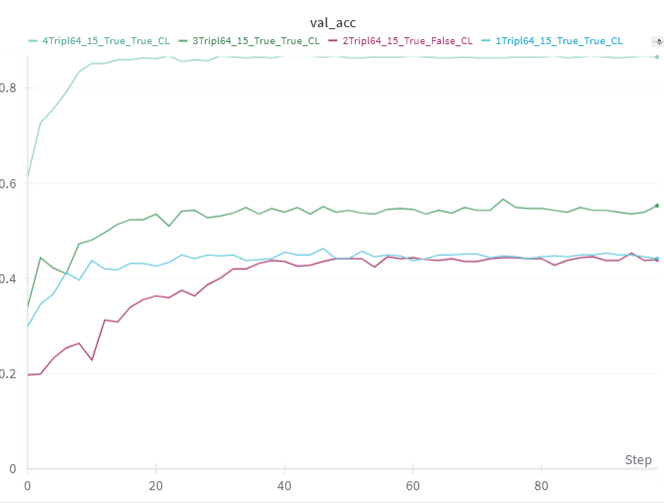
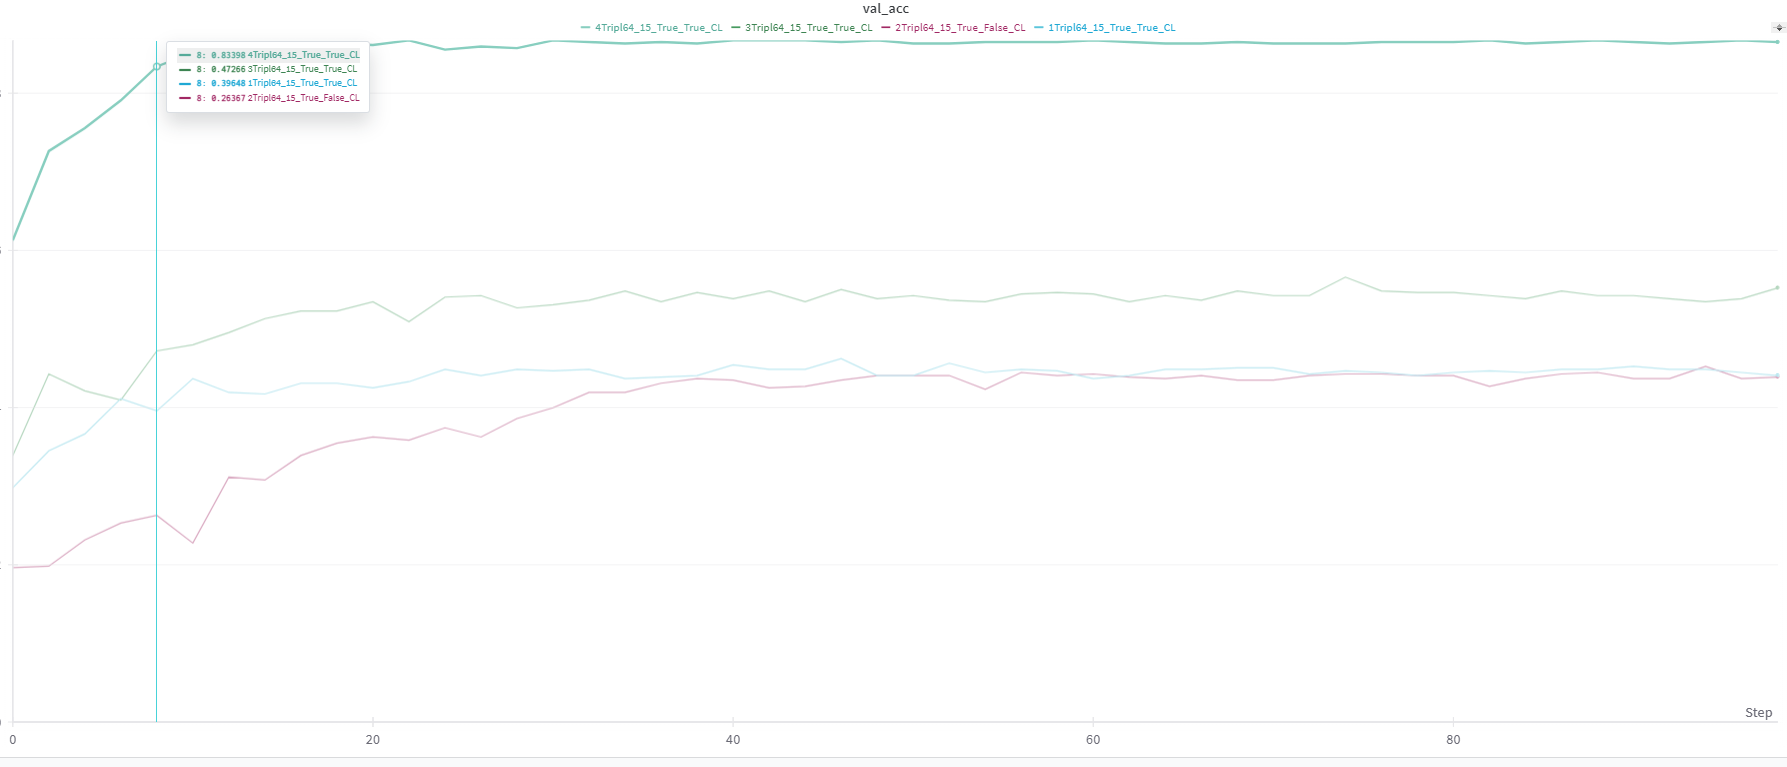

Также добавлю классификацию с помощью SVC и логистической регрессии

In [23]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

names = [
    "LogisticRegression",
    "Linear_SVM",
]

classifiers = [
    LogisticRegression(),
    SVC(kernel="rbf"),
]

In [24]:
scores = pd.DataFrame()
for name, clf in tqdm(zip(names, classifiers)):

    clf.fit(database_tensors_flat, database_labels_flat)
    y_pred = clf.predict(test_tensors_flat)
    acc = round(accuracy_score(test_labels_flat, y_pred), 4)
    f1 = round(f1_score(test_labels_flat, y_pred, average="macro"), 4)
    new_row = {
        "Test": name,
        "Accuracy": acc,
        "F1 score": f1,
    }
    scores = pd.concat([scores, pd.DataFrame([new_row])])

scores = scores.set_index("Test")

run = wandb.init(
    name=f"{experiment_name_triplet}_ML",
    project = "wandb-lightning"
)
wandb.define_metric("Acc_distance", summary="mean")
wandb.define_metric("F1_distance", summary="mean")

log_dict = {
    "Acc_distance": acc,
    "F1_distance": f1,
}
wandb.log(log_dict)
wandb.finish()

display(scores)

0it [00:00, ?it/s]

Acc_distance,▁
F1_distance,▁


,Accuracy,F1 score
Test,,
LogisticRegression,0.8711,0.8341
Linear_SVM,0.8594,0.8087


# Выводы

Результаты экспериментов (номер в названии - номер эксперимента, ML - метрика от SVC, DS - метрика по поиску в базе с наиболее коротким расстоянием)

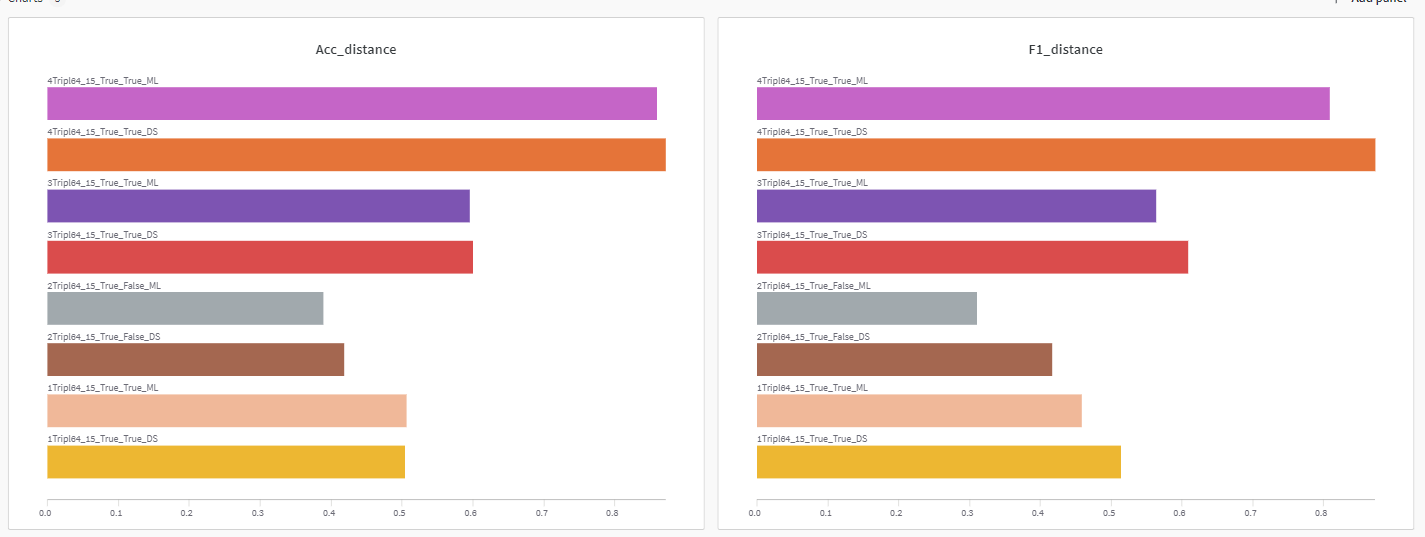

Увеличение кол-ва пара даже до половины всех возможных дало существенный буст в метрике. Есть потенциал, если использовать все данные. В целом удалось улучшить результат от готовой библиотеке в классификации лиц: Accuracy DeepFace 84.6% vs Accuracy на 1/2 комбинаций 87,11%.